# Named Entity Recognition & Topic Modeling

In [ ]:
# installs

!pip install sentence-transformers

In [ ]:
# for Bert NER
!pip install transformers
!pip install simpletransformers

In [ ]:
!pip install umap-learn

In [ ]:
!pip install hdbscan

In [ ]:
# pytorch for GPU

!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


In [5]:
# check if GPU available
import torch
torch.cuda.is_available()

True

In [6]:
# imports

import pandas as pd
import numpy as np

import gensim

from sentence_transformers import SentenceTransformer
import hdbscan
import umap

# import umap.umap_ as umap # ALTERNATIVE UMAP IMPORT

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Read data into movies

movies = pd.read_csv('./mpst_full_data.csv')

# Print head
movies.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [ ]:
# drop coulmns that won't be used
movies = movies.drop(columns=['split', 'synopsis_source'], axis=1)

In [ ]:
movies.head()

,imdb_id,title,plot_synopsis,tags
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good"
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm..."


### PREPROCESSING

Preprocessing of plot_synopsis: 
- remove punctuation
- remove stopwords 
- remove Named Entities (Person) 

In [ ]:
# remove punctuation and stopwords from text
# DO NOT convert to lowercase; Bert NER case-sensitive
def preprocess(text):
    no_punct = gensim.parsing.preprocessing.strip_punctuation(text)
    no_stops = gensim.parsing.preprocessing.remove_stopwords(no_punct)

    return no_stops

movies['plot_text_processed'] = movies['plot_synopsis'].map(lambda x: preprocess(x))

movies['plot_text_processed'].head()

0    Note synopsis orginal Italian release segments...
1    Two thousand years ago Nhagruul Foul sorcerer ...
2    Matuschek s gift store Budapest workplace Alfr...
3    Glenn Holland morning person s standards woken...
4    In May 1980 Cuban man named Tony Montana Al Pa...
Name: plot_text_processed, dtype: object

### NAMED ENTITY REMOVAL

In [ ]:
# BERT named entitiy recognition model

from simpletransformers.ner import NERModel, NERArgs

model_args = NERArgs()
model_args.silent = True # no progress bar when running model (on multiple movies)

englishmodel = NERModel(
        model_type="bert",
        model_name="dslim/bert-base-NER",
        args=model_args,
        use_cuda=True
)

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

In [ ]:
def remove_named_entities_bert(text):
    result = []

    # get named entities in text
    # sensitive to case: input should not be all-lowercase
    prediction, raw_output = englishmodel.predict([text])

    # pred: [[{'Matuschek': 'B-PER'}, {'gift': 'O'}, ...]]
    for tag_dict in prediction[0]:
      for token in tag_dict: # iterate dict keys

        # keep token only if not a person entity
        # person entitities are 'B-PER' and 'I-PER'
        if 'PER' not in tag_dict[token]: 
          result.append(token)
    return ' '.join(result) # text with entities removed


# TEST
test_movie = movies['plot_text_processed'][2]
print(test_movie)
print('RESULT:', remove_named_entities_bert(test_movie))

Matuschek s gift store Budapest workplace Alfred Kralik James Stewart newly hi Ed Klara Novak Margaret Sullavan At work constantly irritate daily aggravation tempered fact secret pen pal trade long soul searching letters Romantic correspondence sent forth Alfred Klara trade barbs work dream someday meeting sensitive caring unknown pen pal Christmas fast approaching store busy Alfred store time treated Mr Matuschek Frank Morgan lately attitude changed Alfred loss Matuschek avoids explanation finally telling Alfred best left Stunned Alfred accepts paycheck says goodbye including Klara For civil A long awaited meeting secret pen pals planned night Alfred having lost job desire Finding t fight curiosity wanders restaurant d agreed meet peeks window fellow employee Of course Klara waiting chosen book wearing red carnation d agreed use signal Realizing d wrong irritation actually masking attraction finally enters goes table reveal true reason aware hurt pen pal t Alfred hurt rudeness finally

In [ ]:
# removed BERT-recognized named entities
movies['plot_text_processed'] = movies['plot_text_processed'].map(lambda x: remove_named_entities_bert(x))

# Synopses after all preprocessing
movies['plot_text_processed'].head()

0    Note synopsis orginal Italian release segments...
1    Two thousand years ago Nhagruul Foul sorcerer ...
2    s gift store Budapest workplace newly hi At wo...
3    morning person s standards woken wife early br...
4    In May 1980 Cuban man named claims asylum Flor...
Name: plot_text_processed, dtype: object

In [ ]:
# more detailed preview on single synopsis
movies.plot_text_processed[0]

'Note synopsis orginal Italian release segments certain order introduces horror tales macabre supernatural known Three Faces Fear THE TELEPHONERosy attractive high priced Parisian girl returns spacious basement apartment evening immediately gets beset series strange phone calls The caller soon identified ex pimp recently escaped prison Rosy terrified testimony landed man jail Looking solace phones lesbian lover The women estranged time certain help agrees come night Seconds later calls promising matter calls protection revenge Unknown Rosy Mary caller impersonating arrives'

In [ ]:
# save preprocessed movies to csv
# maintain all other useful columns e.g. imdb_id, title
# use new csv for code below

movies.to_csv('bert_preprocessed_movies.csv', index=False)



## BERT TOPIC MODELING

Adapted from Maarten Grootendorst's work on topic modeling with BERT:

https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [7]:
# import csv with preprocessed movies
movies = pd.read_csv('./bert_preprocessed_movies.csv')

# Preview movies
movies.head()


,imdb_id,title,plot_synopsis,tags,plot_text_processed
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",Note synopsis orginal Italian release segments...
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,Two thousand years ago Nhagruul Foul sorcerer ...
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,s gift store Budapest workplace newly hi At wo...
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",morning person s standards woken wife early br...
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",In May 1980 Cuban man named claims asylum Flor...


In [8]:
# convert synopses data to list for clustering

movies_list = movies.plot_text_processed.tolist()

print(movies_list[4])

In May 1980 Cuban man named claims asylum Florida USA search American Dream departing Cuba Mariel boatlift 1980 When questioned tough talking INS officials notice tattoo s left arm black heart pitchfork identifies hitman detain camp called Freedomtown Cubans including s best friend Cuban Army buddy Ray local I 95 expressway government evaluates visa petitions After 30 days governmental dithering camp rumors receives offer Cuban Mafia quickly relays If kill Roberto aide detained Freedomtown receive green cards agrees kills riot


In [9]:
# EMBEDDING model

# without GPU
# model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# with GPU
model = SentenceTransformer('distilbert-base-nli-mean-tokens', device='cuda')


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
# transform movie synopses into 768-dimensional vector embeddings:

embeddings = model.encode(movies_list, show_progress_bar=True)

# PREVIEW embeddings
for text, embedding in zip(movies_list, embeddings):
    print("Synopsis:", text)
    print("Embedding:", embedding[:10])
    print(len(embeddings[0]))
    print("")
    break

Batches:   0%|          | 0/464 [00:00<?, ?it/s]

Synopsis: Note synopsis orginal Italian release segments certain order introduces horror tales macabre supernatural known Three Faces Fear THE TELEPHONERosy attractive high priced Parisian girl returns spacious basement apartment evening immediately gets beset series strange phone calls The caller soon identified ex pimp recently escaped prison Rosy terrified testimony landed man jail Looking solace phones lesbian lover The women estranged time certain help agrees come night Seconds later calls promising matter calls protection revenge Unknown Rosy Mary caller impersonating arrives
Embedding: [-0.28233027 -0.5168891   0.7910191  -0.9591836  -0.3102247  -0.05852975
 -0.43264672 -0.6628994   0.4485602   0.3444074 ]
768



In [ ]:
# reduce dimensionality of embeddings for clustering
# a too low dimensionality results in a loss of information while a too high dimensionality results 
# in poorer clustering results 

# tune n_neighbors & n_components to get optimal results 
umap_embeddings = umap.UMAP(n_neighbors=25, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [72]:
# K-means clustering 
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=20, random_state=0).fit(umap_embeddings)

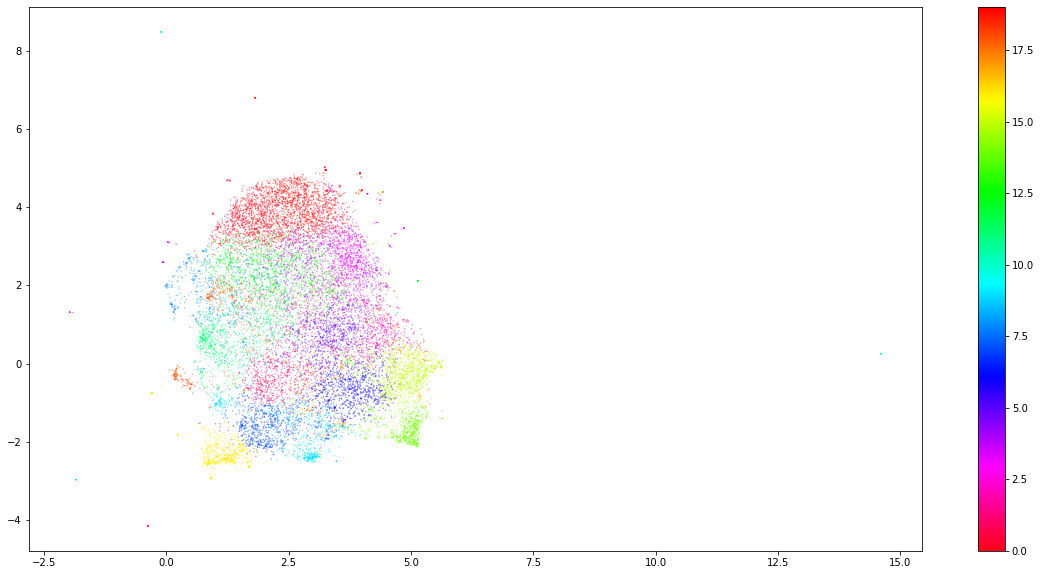

In [73]:
# VISUALIZE movie clusters

# make embeddings 2-dimensional to plot in 2d space
umap_data = umap.UMAP(n_neighbors=25, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# plot clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### CLUSTER TF_IDF

In [74]:
# group movies by cluster to get tf-idf across clusters

movies_df = pd.DataFrame(movies, columns=['plot_text_processed'])
movies_df['Topic'] = cluster.labels_
movies_df['Movie_ID'] = movies.imdb_id
movies_df['Title'] = movies.title
print(movies_df)

movies_per_topic = movies_df.groupby(['Topic'], as_index = False).agg({'plot_text_processed': ' '.join})

                                     plot_text_processed  Topic   Movie_ID  \
0      Note synopsis orginal Italian release segments...      5  tt0057603   
1      Two thousand years ago Nhagruul Foul sorcerer ...      7  tt1733125   
2      s gift store Budapest workplace newly hi At wo...     12  tt0033045   
3      morning person s standards woken wife early br...      8  tt0113862   
4      In May 1980 Cuban man named claims asylum Flor...     18  tt0086250   
...                                                  ...    ...        ...   
14823  In 1988 weatherman Harrisburg Pennsylvania tel...     12  tt0219952   
14824  In Russia media covers s disclosure identity I...      7  tt1371159   
14825  During North African Campaign World War II Cap...     14  tt0063443   
14826  catches unfaithful wife apartment boss apparen...      5  tt0039464   
14827  Sometime 1950s Chicago man returns home work f...     13  tt0235166   

                                               Title  
0       

In [79]:
# save movies with cluster_id (Topic) to csv

movies_df.to_csv('movies_with_topics.csv', index=False)

In [75]:
# cluster-based TF-IDF: 
# treat all documents in a cluster as a single document and then apply TF-IDF

def cluster_tf_idf(movies, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(movies)
    t = count.transform(movies).toarray() # term frequency
    w = t.sum(axis=1) # total number of words
    tf = np.divide(t.T, w) # regularization of frequent words in the cluster
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1) # the total, unjoined, number of documents m is divided by the total frequency of word t across all classes n
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = cluster_tf_idf(movies_per_topic.plot_text_processed.values, m=len(movies_list))

### GET WORDS PER TOPIC

In [ ]:
# get top n words per topic
def top_n_words_per_topic(tf_idf, count, movies_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(movies_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

# get number of movies per topic
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .plot_text_processed
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "plot_text_processed": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = top_n_words_per_topic(tf_idf, count, movies_per_topic, n=20)
topic_sizes = extract_topic_sizes(movies_df)


In [77]:
# get topic count and sizes
print("TOPIC COUNT:", len(topic_sizes))
print()

topic_sizes.head(20)

TOPIC COUNT: 20



,Topic,Size
19,19,1244
0,0,1199
15,15,1039
11,11,891
4,4,849
6,6,841
2,2,840
5,5,831
7,7,784
3,3,774


In [78]:
# inspect the most important words per topic (cluster)

# get top 20 topics
topics = topic_sizes.Topic[:20]

# get top 20 words per topic for top 20 topics
for t in topics:
    print(top_n_words[t][:20])
    print()


[('mother', 0.012133563077918286), ('love', 0.011353456008737519), ('daughter', 0.010543057270909807), ('family', 0.00995396319251385), ('married', 0.00842139003602417), ('wife', 0.00840262642843264), ('sister', 0.00834604103580555), ('marriage', 0.007975795230714695), ('old', 0.007739022260598821), ('husband', 0.00751531002615941), ('father', 0.00744473544375262), ('year', 0.007296286352102224), ('woman', 0.007137343923220253), ('house', 0.007116836578277079), ('son', 0.006984767454992409), ('home', 0.006946783260260494), ('parents', 0.006832858256912007), ('years', 0.0066210478279094), ('life', 0.006611041120071244), ('children', 0.0065468929672527956)]

[('love', 0.009432395631349563), ('party', 0.008576832781289888), ('friends', 0.008222770383220048), ('school', 0.008105682715363098), ('friend', 0.007654225014366395), ('new', 0.00731843005473818), ('girl', 0.00711419104707805), ('york', 0.006722684024222509), ('sex', 0.006361224106424399), ('day', 0.006306411320186986), ('best', 0.